In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls

datalab  drive


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
import keras
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import re
%matplotlib inline

In [0]:
n_samples = 200000
max_len = 20

In [0]:
data_path = 'drive/projects/QuoteGen/data'
if not os.path.exists(data_path):
  os.mkdir(data_path)

In [0]:
models_path = 'drive/projects/QuoteGen/models'
if not os.path.exists(models_path):
  os.mkdir(models_path)

In [0]:
data_txt = os.path.join(data_path, 'quotes.txt')
data_csv = os.path.join(data_path, 'quotes_all.csv')

In [262]:
quotes_ds = []
if os.path.exists(os.path.join(data_path,"quotes_pickle.pkl")):
  with open(os.path.join(data_path,"quotes_pickle.pkl"),'rb') as f:
    quotes_ds = pickle.load(f)
else:
  with open(data_csv) as f:
    for line in f.readlines():
      quotes_ds.append(line.split(";")[0])
  # Pickling the dataset
  if not os.path.exists(os.path.join(data_path,'quotes_pickle.pkl')):
    out = open(os.path.join(data_path,"quotes_pickle.pkl"),'wb')
    pickle.dump(quotes_ds, out)
print("Found %d quotes"%len(quotes_ds))

Found 75966 quotes


In [0]:
def clean_sentences(sentences, lower = True):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
      sentence = re.sub(r'[0-9#$%&*+():=?/]+', '', sentence)
      if lower==True:
        temp = "\t "+sentence.lower()+ " \n"
      else:
        temp = "\t "+sentence+ " \n"
      n_sentences.append(temp)
      temp=''
    return n_sentences

In [0]:
cleaned_quotes = clean_sentences(quotes_ds, lower=True)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [300]:
tokenizer = Tokenizer(split=' ', char_level=True)
tokenizer.fit_on_texts(cleaned_quotes)
sequences = tokenizer.texts_to_sequences(cleaned_quotes)

word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))

Found 35 unique tokens.


In [0]:
#   out = open(os.path.join(data_path,"word_index.pkl"),'wb')
#   pickle.dump(word_index, out)

if not os.path.exists(os.path.join(data_path,'word_index_cleaned.pkl')):
  with open(os.path.join(data_path,"word_index_cleaned.pkl"), 'wb') as handle:
      pickle.dump(word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
  with open(os.path.join(data_path,"word_index_cleaned.pkl"), 'rb') as handle:
      word_index = pickle.load(handle)

In [0]:
index2char = {}
for ch in tokenizer.word_index:
  index2char[tokenizer.word_index.get(ch)] = ch

In [303]:
test = sequences[0]
s = ""
for temp in test:
  if not temp==0:
    s = s+ index2char[temp]
    
cleaned_quotes[0],s

("\t age is an issue of mind over matter. if you don't mind, it doesn't matter. \n",
 "\t age is an issue of mind over matter. if you don't mind, it doesn't matter. \n")

In [0]:
def generate_split(data, lookback= 20, step = 5):
  sentence = []
  next_char = []
  for d in data: 
    for i in range(lookback,len(d), step):
      sentence.append(d[i-lookback:i])
      next_char.append(d[i])
  print(len(sentence))
  return sentence, next_char

In [305]:
sentence, next_char = generate_split(cleaned_quotes,lookback = max_len, step = 10)

985265


In [0]:
n_tokens = len(word_index)+1

x = np.zeros((n_samples, max_len, n_tokens))
y = np.zeros((n_samples, n_tokens))

for i,s in enumerate(sentence[:n_samples]):
  for t, char in enumerate(s):
      x[i, t, word_index[char]] = 1
  y[i, word_index[next_char[i]]] = 1

In [0]:
from keras.models import Sequential
from keras import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten,Dropout, Conv1D,MaxPool1D
from keras.optimizers import RMSprop
from keras.models import load_model

In [0]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(max_len, n_tokens),return_sequences= True))
model2.add(Dropout(0.3))
model2.add(LSTM(128))
model2.add(Dropout(0.3))
model2.add(Dense(n_tokens,activation='softmax'))

In [0]:
model2 = load_model(os.path.join(models_path,'quotegen_test.h5'))

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.1,
            patience=1,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(models_path,'quotegen_test.h5'),
            monitor='loss',
            save_best_only=True,
        ),
]

In [322]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 20, 128)           84480     
_________________________________________________________________
dropout_31 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 36)                4644      
Total params: 220,708
Trainable params: 220,708
Non-trainable params: 0
_________________________________________________________________


In [323]:
epochs = 100

history = model2.fit(x, y, batch_size=512, epochs=epochs, verbose =1, callbacks = callbacks_list)

Epoch 1/100
200000/200000 [==============================] - 44s 219us/step - loss: 1.3396
Epoch 2/100
194560/200000 [============================>.] - ETA: 1s - loss: 1.3495

200000/200000 [==============================] - 41s 203us/step - loss: 1.3497
Epoch 3/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.3041
Epoch 4/100
 68096/200000 [=========>....................] - ETA: 26s - loss: 1.2816

200000/200000 [==============================] - 41s 203us/step - loss: 1.2874
Epoch 5/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2737
Epoch 6/100
 26624/200000 [==>...........................] - ETA: 35s - loss: 1.2634

200000/200000 [==============================] - 40s 200us/step - loss: 1.2682
Epoch 7/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2640
Epoch 8/100
 11776/200000 [>.............................] - ETA: 38s - loss: 1.2403

200000/200000 [==============================] - 40s 199us/step - loss: 1.2594
Epoch 9/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2569
Epoch 10/100
 11776/200000 [>.............................] - ETA: 38s - loss: 1.2514

200000/200000 [==============================] - 40s 200us/step - loss: 1.2550
Epoch 11/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2490
Epoch 12/100
  9216/200000 [>.............................] - ETA: 39s - loss: 1.2698

200000/200000 [==============================] - 40s 202us/step - loss: 1.2484
Epoch 13/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.2449
Epoch 14/100
 11776/200000 [>.............................] - ETA: 38s - loss: 1.2445

200000/200000 [==============================] - 40s 202us/step - loss: 1.2427
Epoch 15/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2425
Epoch 16/100
 11776/200000 [>.............................] - ETA: 38s - loss: 1.2827

200000/200000 [==============================] - 40s 199us/step - loss: 1.2383
Epoch 17/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2376
Epoch 18/100
  3072/200000 [..............................] - ETA: 42s - loss: 1.2363

200000/200000 [==============================] - 40s 200us/step - loss: 1.2359
Epoch 19/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2359
Epoch 20/100
  5632/200000 [..............................] - ETA: 40s - loss: 1.2642

200000/200000 [==============================] - 40s 199us/step - loss: 1.2282
Epoch 21/100
200000/200000 [==============================] - 40s 198us/step - loss: 1.2280
Epoch 22/100
  9216/200000 [>.............................] - ETA: 39s - loss: 1.2129

200000/200000 [==============================] - 40s 198us/step - loss: 1.2252
Epoch 23/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2274
Epoch 24/100
  8192/200000 [>.............................] - ETA: 38s - loss: 1.2201

200000/200000 [==============================] - 40s 199us/step - loss: 1.2245
Epoch 25/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.2253
Epoch 26/100
 12800/200000 [>.............................] - ETA: 38s - loss: 1.2208

200000/200000 [==============================] - 40s 202us/step - loss: 1.2242
Epoch 27/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2275
Epoch 28/100
  8192/200000 [>.............................] - ETA: 38s - loss: 1.2292

200000/200000 [==============================] - 40s 202us/step - loss: 1.2304
Epoch 29/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.2258
Epoch 30/100
 12288/200000 [>.............................] - ETA: 37s - loss: 1.2193

200000/200000 [==============================] - 40s 201us/step - loss: 1.2256
Epoch 31/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2257
Epoch 32/100
 11264/200000 [>.............................] - ETA: 38s - loss: 1.2365

200000/200000 [==============================] - 40s 202us/step - loss: 1.2248
Epoch 33/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.2255
Epoch 34/100
 12288/200000 [>.............................] - ETA: 37s - loss: 1.2234

200000/200000 [==============================] - 41s 203us/step - loss: 1.2283
Epoch 35/100
200000/200000 [==============================] - 40s 202us/step - loss: 1.2243
Epoch 36/100
 13312/200000 [>.............................] - ETA: 37s - loss: 1.2283

200000/200000 [==============================] - 40s 200us/step - loss: 1.2276
Epoch 37/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2253
Epoch 38/100
  8192/200000 [>.............................] - ETA: 37s - loss: 1.2143

200000/200000 [==============================] - 39s 196us/step - loss: 1.2253
Epoch 39/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2246
Epoch 40/100
  5120/200000 [..............................] - ETA: 39s - loss: 1.1885

200000/200000 [==============================] - 40s 198us/step - loss: 1.2265
Epoch 41/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2255
Epoch 42/100
  2560/200000 [..............................] - ETA: 39s - loss: 1.2233

200000/200000 [==============================] - 40s 199us/step - loss: 1.2226
Epoch 43/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2239
Epoch 44/100
  4608/200000 [..............................] - ETA: 39s - loss: 1.2306

200000/200000 [==============================] - 40s 198us/step - loss: 1.2239
Epoch 45/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2262
Epoch 46/100
  1024/200000 [..............................] - ETA: 40s - loss: 1.2245

200000/200000 [==============================] - 40s 200us/step - loss: 1.2241
Epoch 47/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2248
Epoch 48/100
  2048/200000 [..............................] - ETA: 39s - loss: 1.1760

200000/200000 [==============================] - 40s 199us/step - loss: 1.2265
Epoch 49/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2236
Epoch 50/100
   512/200000 [..............................] - ETA: 41s - loss: 1.2015

200000/200000 [==============================] - 40s 200us/step - loss: 1.2265
Epoch 51/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2244
Epoch 52/100
  5120/200000 [..............................] - ETA: 39s - loss: 1.2160

200000/200000 [==============================] - 40s 199us/step - loss: 1.2259
Epoch 53/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2267
Epoch 54/100
  6656/200000 [..............................] - ETA: 38s - loss: 1.2098

200000/200000 [==============================] - 40s 199us/step - loss: 1.2253
Epoch 55/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2267
Epoch 56/100
  5632/200000 [..............................] - ETA: 38s - loss: 1.2350

200000/200000 [==============================] - 40s 200us/step - loss: 1.2252
Epoch 57/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2241
Epoch 58/100
  3072/200000 [..............................] - ETA: 39s - loss: 1.2589

200000/200000 [==============================] - 40s 200us/step - loss: 1.2248
Epoch 59/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2242
Epoch 60/100
  5632/200000 [..............................] - ETA: 38s - loss: 1.2096

200000/200000 [==============================] - 40s 199us/step - loss: 1.2255
Epoch 61/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2256
Epoch 62/100
  5120/200000 [..............................] - ETA: 38s - loss: 1.2319

200000/200000 [==============================] - 40s 199us/step - loss: 1.2253
Epoch 63/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2265
Epoch 64/100
  5632/200000 [..............................] - ETA: 39s - loss: 1.2341

200000/200000 [==============================] - 40s 200us/step - loss: 1.2231
Epoch 65/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2287
Epoch 66/100
  9216/200000 [>.............................] - ETA: 38s - loss: 1.2264

200000/200000 [==============================] - 40s 201us/step - loss: 1.2250
Epoch 67/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2238
Epoch 68/100
  8192/200000 [>.............................] - ETA: 38s - loss: 1.1908

200000/200000 [==============================] - 40s 199us/step - loss: 1.2251
Epoch 69/100
199168/200000 [============================>.] - ETA: 0s - loss: 1.2245

200000/200000 [==============================] - 40s 198us/step - loss: 1.2246
Epoch 70/100
200000/200000 [==============================] - 40s 198us/step - loss: 1.2247
Epoch 71/100
 56320/200000 [=======>......................] - ETA: 28s - loss: 1.2328

200000/200000 [==============================] - 40s 200us/step - loss: 1.2250
Epoch 72/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2249
Epoch 73/100
 18944/200000 [=>............................] - ETA: 36s - loss: 1.2084

200000/200000 [==============================] - 40s 199us/step - loss: 1.2254
Epoch 74/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2250
Epoch 75/100
  8192/200000 [>.............................] - ETA: 38s - loss: 1.2395

200000/200000 [==============================] - 40s 199us/step - loss: 1.2243
Epoch 76/100
200000/200000 [==============================] - 40s 198us/step - loss: 1.2250
Epoch 77/100
  7168/200000 [>.............................] - ETA: 38s - loss: 1.2187

200000/200000 [==============================] - 40s 201us/step - loss: 1.2254
Epoch 78/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2237
Epoch 79/100
  5632/200000 [..............................] - ETA: 39s - loss: 1.2225

200000/200000 [==============================] - 40s 200us/step - loss: 1.2273
Epoch 80/100
200000/200000 [==============================] - 40s 201us/step - loss: 1.2240
Epoch 81/100
  6656/200000 [..............................] - ETA: 38s - loss: 1.2282

200000/200000 [==============================] - 40s 200us/step - loss: 1.2245
Epoch 82/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2246
Epoch 83/100
  3072/200000 [..............................] - ETA: 39s - loss: 1.2485

200000/200000 [==============================] - 40s 198us/step - loss: 1.2240
Epoch 84/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2257
Epoch 85/100
  2048/200000 [..............................] - ETA: 39s - loss: 1.2303

200000/200000 [==============================] - 40s 199us/step - loss: 1.2272
Epoch 86/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2256
Epoch 87/100
  4096/200000 [..............................] - ETA: 38s - loss: 1.2252

200000/200000 [==============================] - 40s 198us/step - loss: 1.2255
Epoch 88/100
200000/200000 [==============================] - 40s 198us/step - loss: 1.2250
Epoch 89/100
  3584/200000 [..............................] - ETA: 39s - loss: 1.2129

200000/200000 [==============================] - 40s 199us/step - loss: 1.2266
Epoch 90/100
200000/200000 [==============================] - 40s 199us/step - loss: 1.2250
Epoch 91/100
  3584/200000 [..............................] - ETA: 39s - loss: 1.2049

200000/200000 [==============================] - 39s 197us/step - loss: 1.2247
Epoch 92/100
193536/200000 [============================>.] - ETA: 1s - loss: 1.2268

200000/200000 [==============================] - 39s 196us/step - loss: 1.2263
Epoch 93/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2242
Epoch 94/100
 56320/200000 [=======>......................] - ETA: 28s - loss: 1.2243

200000/200000 [==============================] - 39s 196us/step - loss: 1.2260
Epoch 95/100
200000/200000 [==============================] - 39s 197us/step - loss: 1.2259
Epoch 96/100
 16896/200000 [=>............................] - ETA: 36s - loss: 1.2292

200000/200000 [==============================] - 39s 197us/step - loss: 1.2256
Epoch 97/100
200000/200000 [==============================] - 39s 196us/step - loss: 1.2222
Epoch 98/100
  7168/200000 [>.............................] - ETA: 40s - loss: 1.2320

200000/200000 [==============================] - 40s 199us/step - loss: 1.2275
Epoch 99/100
200000/200000 [==============================] - 40s 200us/step - loss: 1.2235
Epoch 100/100
  7168/200000 [>.............................] - ETA: 37s - loss: 1.2053

200000/200000 [==============================] - 40s 199us/step - loss: 1.2248


In [0]:
def sample(preds, temperature= 0.2):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds+1e-25)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [0]:
def inference(sent):
  string_length=20
  string_revised=sent.ljust(string_length)
  return string_revised

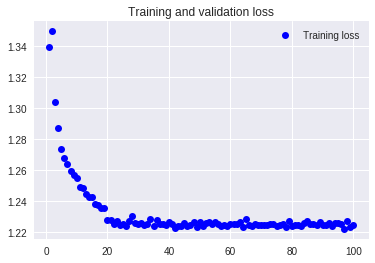

In [327]:
import matplotlib.pyplot as plt
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [363]:
start_word="love "
inference_text = inference(start_word)

for i in range(10):
    sys.stdout.write(inference_text.strip()+" ")
    generated_text = inference_text[:20]+""
    for i in range(100):
      sampled = np.zeros((1, max_len, n_tokens))
      for t, char in enumerate(generated_text):
          sampled[0, t, word_index[char]] = 1.
      preds = model2.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = index2char[next_index]
      if next_char =='\n':
        
        break
      generated_text += next_char
      generated_text = generated_text[1:]
      sys.stdout.write(next_char)
    print("\n-")

love who love has not a car completely do it and the art of the picking to see and i get to realize that 
-
love and the way i'm not at the family and there's a songs because i was a major thinking and you feel th
-
love your dad in the environment are in the world. 
-
love with the family about something when i always the only came so much something he does not change a p
-
love you are cool. 
-
love it is best of the courage to person and the people are not going to spent it that we can all somethi
-
love really death is to me my car is the most beauty of the good and a same things i was a children, and 
-
love with it - that was not our song in the product and a man of the publing the ompare time of created i
-
love you delicism is the formula is a little amazing. 
-
love is me and i was a country to be in the best sense of the cool to come out to present a food with my 
-
